In [1]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: April 26, 2018

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import glob, os
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import pandas as pd
import logging
import yaml
import json
from PIL import Image as pil_image

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
from keras.utils.np_utils import to_categorical
from NeMO_models import FCN
import NeMO_layers
import NeMO_encoders
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook

model = load_model('./tmp/SharpMask_Jarrett256_v2.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D})

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [4]:
# Test export of patches from gdal
imgpath = 'F:/Images/Fiji/mosaiced_001.TIF'
# imgpath = '../Images/Jarrett_Training_Patches/Coral/Coral_00000001.tif'
truthpath = 'F:/Images/Fiji/truth_classes_wcldMask_001.TIF'
# truthpath = '../Images/Jarrett_TrainingRef_Patches/Coral/Coral_00000001.png'
output_trainpath = '../Images/Fiji_Training_Patches/'
output_trainrefpath = '../Images/Fiji_TrainingRef_Patches/'
output_trainfilename = 'rastertrain.txt'
output_validpath = '../Images/Fiji_Valid_Patches/'
output_validrefpath = '../Images/Fiji_ValidRef_Patches/'
output_validfilename = 'rastervalid.txt'
jsonpath = './utils/CoralClasses.json'

with open(jsonpath) as json_file:
    json_data = json.load(json_file)

Fiji = coralutils.CoralData(imgpath, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
# Fiji = coralutils.CoralData(imgpath, Truthpath=truthpath, load_type="raster")
Fiji.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
Fiji.Consolidate_classes(newclassdict=json_data["VedConsolidated_ClassDict"], transferdict=json_data["L32VedConsolidated_Dict"])
labelkey = json_data["VedConsolidated_ClassDict"]
class_indices_rev = dict((v,k) for k,v in labelkey.items()) #flip k,v

# print(Fiji.consolclass_weights)
# print(Fiji.consolclass_count)

with open("init_args - Jarrett.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])

if train_loader.color_mode == 'rgb':
    num_channels = 3
elif train_loader.color_mode == '8channel':
    num_channels = 8
y = train_loader.target_size[1]
x = train_loader.target_size[0]

pixel_mean = 100*np.ones(num_channels)
pixel_std = 100*np.ones(num_channels)
# datagen = NeMOImageGenerator(image_shape = (y,x,num_channels),
#     image_resample=True, pixelwise_center=True,
#     pixel_mean=pixel_mean, pixelwise_std_normalization=True,
#     pixel_std=pixel_std)

# train_generator = datagen.flow_from_NeMOdirectory(output_trainpath,
#     target_size=(y,x),
#     color_mode='8channel',
#     passedclasses = labelkey,
#     class_mode = 'categorical',
#     batch_size = 6,
#     shuffle=True)

./utils\loadcoraldata_utils.py:217: RuntimeWarning: divide by zero encountered in long_scalars
  self.consolclass_weights = dict((k, (self.truthimage_consolidated.shape[0]*self.truthimage_consolidated.shape[1])/(self.truthimage_consolidated==newclassdict[k]).sum()) for k in newclassdict)


(1024, 1024)


<IPython.core.display.Javascript object>


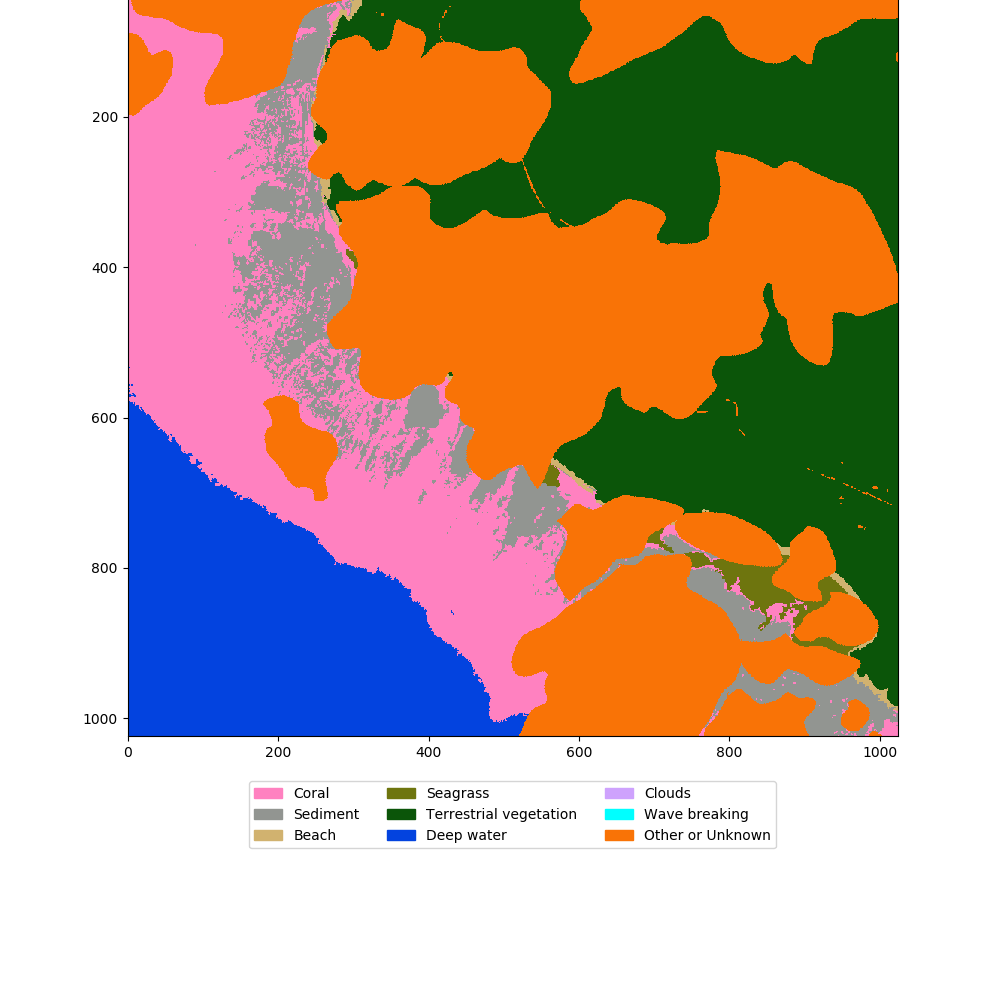

In [17]:
cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(len(cmap_Ved.colors))]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)

xstart = 800
xlen = 1024
# xlen = 3840
ystart = 3000
ylen = 1024
# ylen = 3200

# ystart=0
# xstart=0
# ylen=256
# xlen=256

predict_size = x

Fiji.testimage = Fiji.image[ystart:ystart+ylen,xstart:xstart+xlen,:]
# Fiji.testimage = Fiji.image
crop_len = int(np.floor(x/2))
offstart = crop_len-int(np.floor(predict_size/2))
Testtruth = Fiji.truthimage_consolidated[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart,0]

print(Testtruth.shape)
# tempimage = Fiji.testimage*100+100
tempimage = Fiji.testimage

max_R = np.max(tempimage[:,:,4])
max_G = np.max(tempimage[:,:,2])
max_B = np.max(tempimage[:,:,1])
Fiji_RGB = np.rollaxis(np.asarray([1/max_R*tempimage[:,:,4], 1/max_G*tempimage[:,:,2], 1/max_B*tempimage[:,:,1]]),0,3)
# print(np.unique(Testtruth))

# fig = plt.figure(1,figsize=(10,10))
# plt.imshow(Fiji_RGB)

fig = plt.figure(1,figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(Testtruth.astype(int), interpolation='nearest', cmap=cmap_Ved, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
plt.show()

# print(Fiji.truthimage[250,50])

In [18]:
class_indices_rev = dict((v,k) for k,v in labelkey.items()) #flip k,v
print(class_indices_rev)

Fiji.set_mean_std(100,100)
# class_dict_min = np.min([Fiji.consolidated_class_dict[k] for k in Fiji.consolidated_class_dict])
print("Total Lines: ", Fiji.testimage.shape[0])
whole_predict, num_predict, prob_predict, truth_predict, accuracy = \
    Fiji.predict_on_whole_image(model, image_size = x, num_classes = len(class_indices_rev), spacing = (64,64), predict_size = predict_size, num_lines=None, lastchannelremove=False)
# for i in range(whole_predict.shape[0]):
#     for j in range(whole_predict.shape[1]):
#         whole_predict[i,j] = train_generator.class_indices[class_indices_rev[whole_predict[i,j]]]

# accuracy_new = 100*np.asarray((whole_predict+class_dict_min == Testtruth)).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
# print(accuracy_new)
# print(accuracy)

{1: 'Coral', 2: 'Sediment', 3: 'Beach', 4: 'Seagrass', 5: 'Terrestrial vegetation', 6: 'Deep water', 7: 'Clouds', 8: 'Wave breaking', 9: 'Other or Unknown'}
Total Lines:  1024


<IPython.core.display.Javascript object>


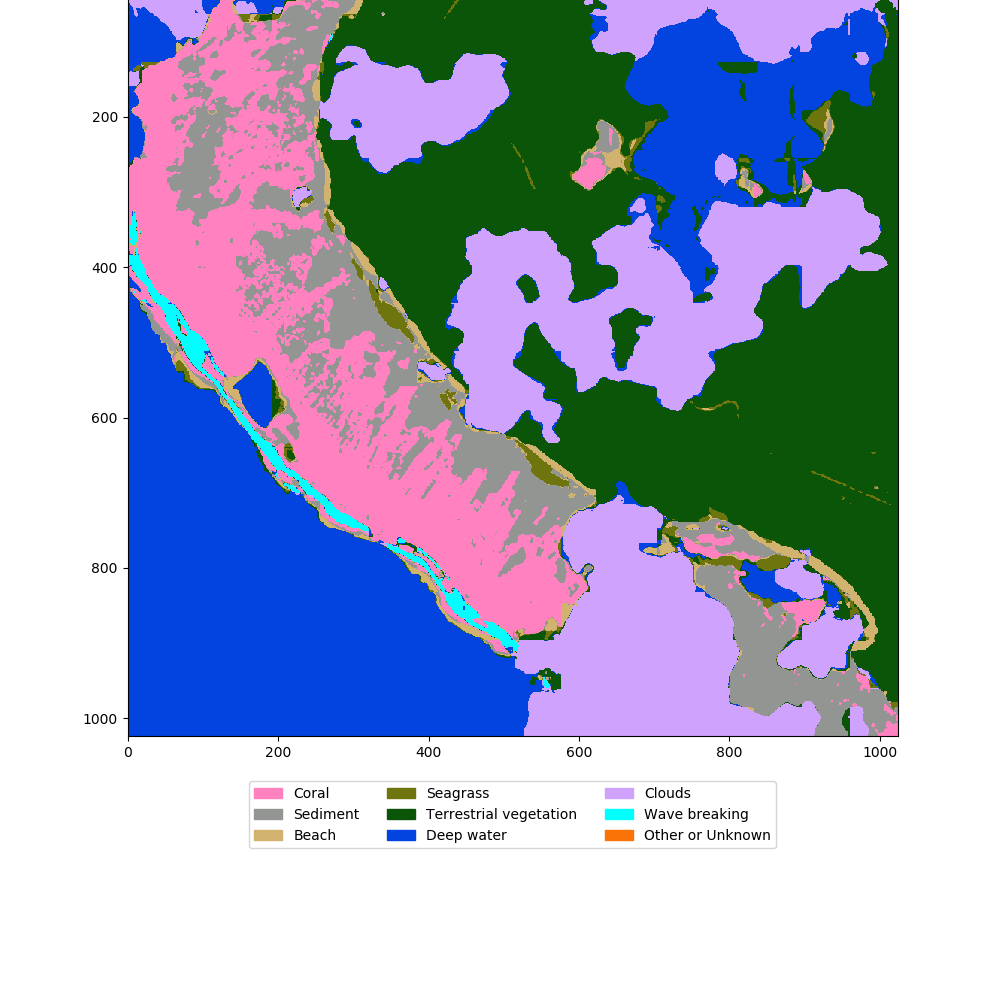

<IPython.core.display.Javascript object>


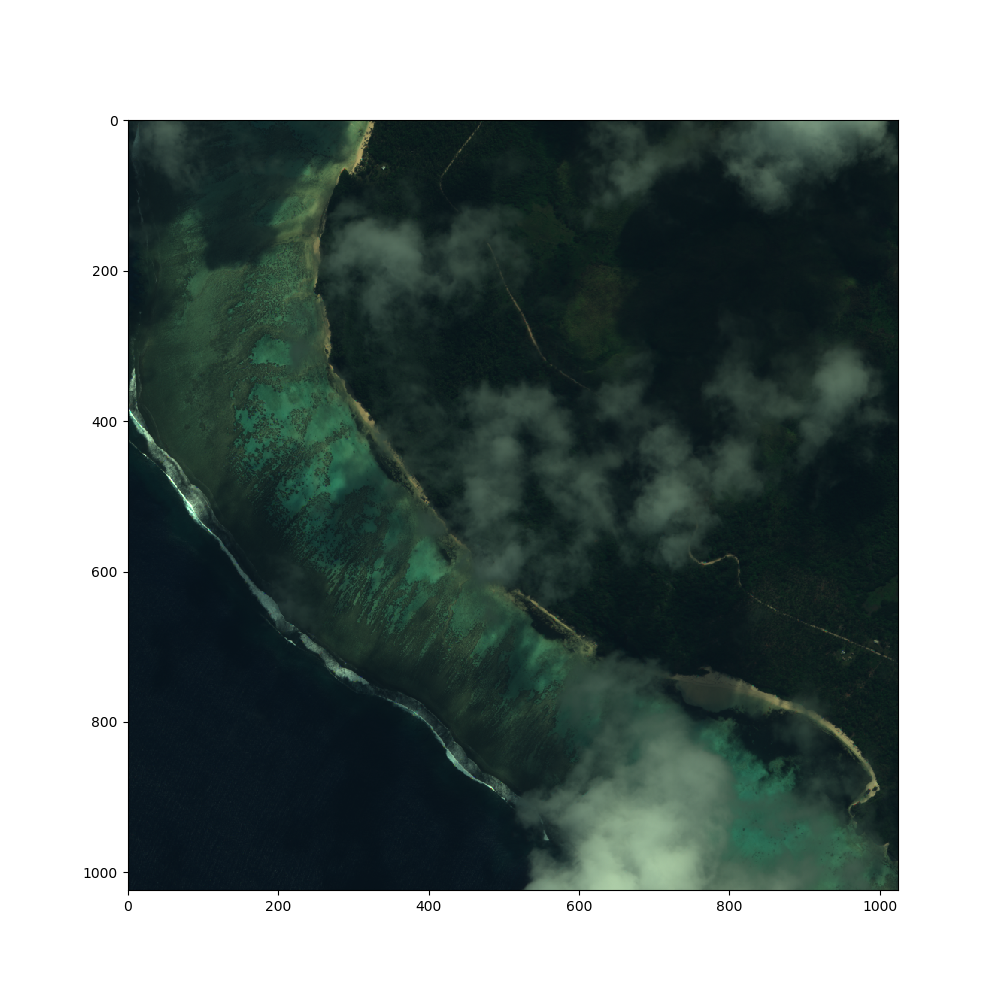

In [19]:
# cmap = colors.ListedColormap(['xkcd:black', '#ae729b', '#7d3fba', '#8f7ab4', '#51528c',
#                              '#846a99', 'xkcd:white', '#d83f3f', '#f140a0', 'xkcd:blue', '#ff8181',
#                              '#161616', '#ec684e', '#f8f8f8', '#142050', '#2ca4ab',
#                              '#303e77', '#189d60', '#916d9e', '#b487af',
#                              '#d35583', '#c214db', '#ab31b2', 'xkcd:murky green'])
cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i-0.5 for i in range(len(cmap_Ved.colors)+1)] # assumes labels start at 0
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)
# bounds = [i-0.5 for i in range(25)]
#norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap.N)


fig = plt.figure(3,figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(whole_predict.astype(int), interpolation='nearest', cmap=cmap_Ved, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)

# ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(24)], ['{}'.format(class_indices_rev[k]) for k in class_indices_rev], loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=2)
# ax.set_axis_off()
ax.set_title('Neural Network Predicted')
# fig.savefig('Hyperopt_Visualize.png', bbox_inches='tight')

fig = plt.figure(4,figsize=(10,10))
plt.imshow(Fiji_RGB)
plt.show()


# fig = plt.figure(3,figsize=(10,10))
# ax = plt.subplot(111)
# ax.imshow(Testtruth-1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.2,
#                  box.width, box.height])
# # ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(24)],
# #               ['{}'.format(class_indices_rev[k]) for k in class_indices_rev],
# #               loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=2)
# ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
#            ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
#           loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
# ax.set_title('ECognition Predicted')
# # ax.set_axis_off()
# # fig.savefig('Ecognition_Reference.png', bbox_inches='tight')
# plt.show()

In [20]:
# Conditional random field code
import pydensecrf.densecrf as dcrf
from cv2 import imread, imwrite
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax

prob_predict_switch = np.rollaxis(prob_predict,2,0)
U = unary_from_softmax(prob_predict_switch)
d = dcrf.DenseCRF2D(xlen, ylen,len(class_indices_rev))
d.setUnaryEnergy(U)
pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3), shape=whole_predict.shape[:2])
d.addPairwiseEnergy(pairwise_gaussian, compat=1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
pairwise_bilateral = create_pairwise_bilateral(sdims=(1,1), schan=100, img=Fiji.testimage, chdim=2)
d.addPairwiseEnergy(pairwise_bilateral, compat=1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

Q, tmp1, tmp2 = d.startInference()
for i in range(20):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d.stepInference(Q, tmp1, tmp2)

KL-divergence at 0: -1647724.6277693133
KL-divergence at 1: -1811885.4558197823
KL-divergence at 2: -1829472.011358323
KL-divergence at 3: -1833997.6288362578
KL-divergence at 4: -1835550.5604793588
KL-divergence at 5: -1836183.1407796326
KL-divergence at 6: -1836470.0328058437
KL-divergence at 7: -1836611.1586986398
KL-divergence at 8: -1836687.295587924
KL-divergence at 9: -1836730.1781108906
KL-divergence at 10: -1836753.992523367
KL-divergence at 11: -1836768.1017356468
KL-divergence at 12: -1836776.7506401055
KL-divergence at 13: -1836782.8551518717
KL-divergence at 14: -1836786.2146483026
KL-divergence at 15: -1836789.0223079575
KL-divergence at 16: -1836790.8898015183
KL-divergence at 17: -1836792.1627221988
KL-divergence at 18: -1836793.0390353084
KL-divergence at 19: -1836793.654525497


<IPython.core.display.Javascript object>


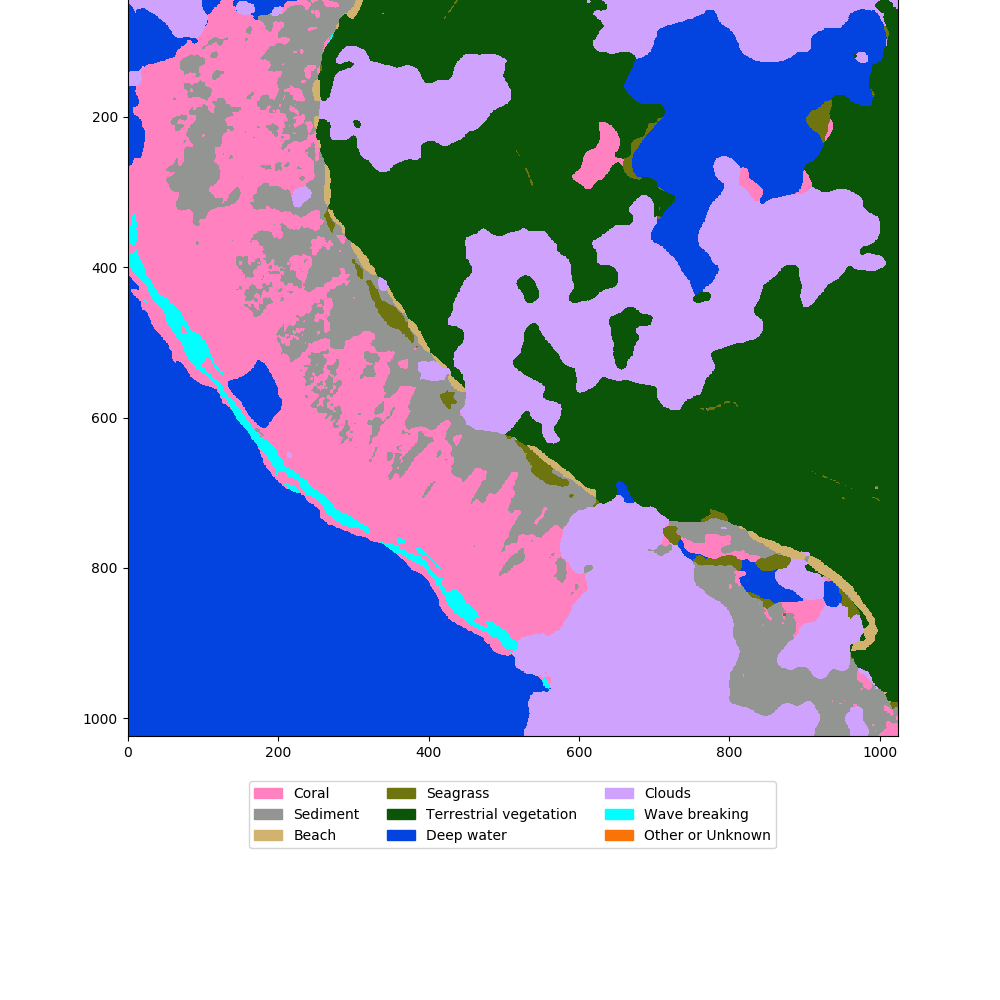

In [21]:
MAP = np.argmax(Q, axis=0)
final_predict = np.reshape(MAP, (ylen, xlen))
# accuracy = 100*np.asarray((final_predict == Testtruth_consolidated)).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
# print(accuracy)

fig = plt.figure(5,figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(final_predict, interpolation='nearest', cmap=cmap_Ved, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
# ax.set_axis_off()
plt.show()